# Path Tracing Notebook
The first 5 code cells are required only on Google Colab. Ignore them if you are running the notebook from your local machine.

In [ ]:
# 1. Run only if you need to delete cached folder from Google Colab
!rm -rf /content/light-transport

In [ ]:
# 2. Download the project files from Github
!git clone https://github.com/dipanjan92/light-transport.git

In [ ]:
# 3. Add the project directory to the system PATH
import sys
sys.path.insert(0,'/content/light-transport/LightTransportSimulator')

In [ ]:
# 4. PyVista is used to generate 3D objects
!pip install pyvista

In [1]:
# 5. Switch to project directory
import os
os.chdir('/content/light-transport/')
os.getcwd()

FileNotFoundError: [WinError 3] The system cannot find the path specified: '/content/light-transport/'

********************************************************************************************

In [1]:
import math
import shutil
import time
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import numba
import pyvista as pv

In [2]:
from LightTransportSimulator.light_transport.src.scene import Scene, Light
from LightTransportSimulator.light_transport.src.primitives import Triangle, PreComputedTriangle
from LightTransportSimulator.light_transport.src.cornell_box import get_cornell_box, get_floor
from LightTransportSimulator.light_transport.src.constants import *

C:\Users\dipanjan\Anaconda3\envs\dsenv\lib\site-packages\pyvista\jupyter\notebook.py:60: UserWarning: Failed to use notebook backend: 

Please install `ipyvtklink` to use this feature: https://github.com/Kitware/ipyvtklink

Falling back to a static output.
  warnings.warn(


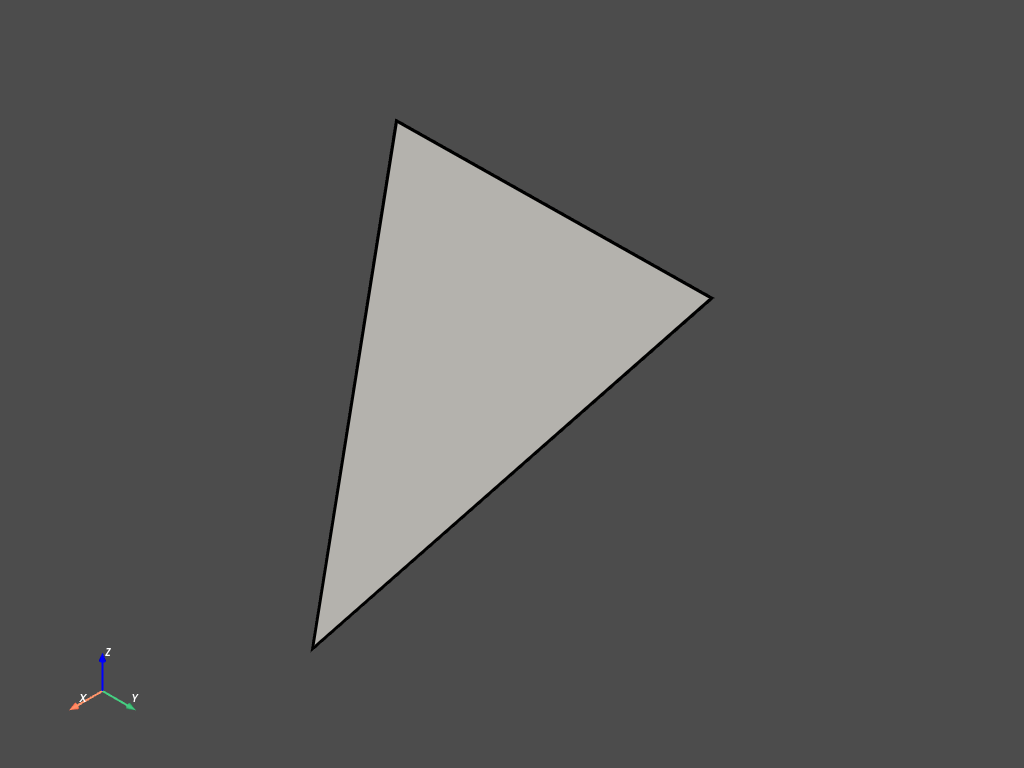

In [3]:
# load a 3D object using PyVista
mesh = pv.Cone(radius=2, center=[0,0,0], height=5, resolution=3)
mesh.rotate_y(45, inplace=True)

# mesh = pv.ParametricEllipsoid(10, 5, 5)
# mesh = mesh.decimate_pro(0.75)
# ********* don't try this on Colab ************
mesh.plot(show_edges=True, line_width=5)

In [4]:

tri = mesh.triangulate()
points = np.ascontiguousarray(tri.points)
faces = tri.faces.reshape((-1,4))[:, 1:4]
vertices = np.ascontiguousarray(points[faces], dtype=np.float64)
len(vertices)


4

In [5]:
#set scene depths

xmax, ymax, zmax = points.max(axis=0)
xmin, ymin, zmin = points.min(axis=0)

# set padding to be added around the object
padding = 5
depth = abs(max(xmax, ymax, zmax)) + padding
x_depth = abs(xmax) + 10
y_depth = abs(ymax) + 1
z_depth = abs(zmax) + 10
xmax, ymax, zmax, depth

(1.767767, 2.0, 2.9925117, 7.992511749267578)

In [6]:
# Initialise an empty list for primitives
objects = numba.typed.List()

In [7]:
from LightTransportSimulator.light_transport.src.cornell_box import get_floor

# Set wall colors and materials for the Cornell box

surface_color = WHITE_2
left_wall_color = RED
right_wall_color = GREEN
surface_mat = Material(color=surface_color, shininess=30, reflectance=0.1, ior=1.5210, transmittance=1) # calcium sulphate
left_wall_mat = Material(color=left_wall_color, shininess=30, reflectance=0.1, ior=1.5210, transmittance=1)
right_wall_mat = Material(color=right_wall_color, shininess=30, reflectance=0.1, ior=1.5210, transmittance=1)

# Get the triangles required to render the Cornell box
objects = get_cornell_box(depth, surface_mat, left_wall_mat, right_wall_mat)
# objects = get_floor(x_depth, y_depth, z_depth, surface_mat)

In [8]:
# Add the triangles in the list of objects
for v in vertices:
    a,b,c = np.append(v[0], 1),np.append(v[1], 1),np.append(v[2], 1)

    triangle = PreComputedTriangle(vertex_1=np.ascontiguousarray(a, dtype=np.float64),
                                   vertex_2=np.ascontiguousarray(b, dtype=np.float64),
                                   vertex_3=np.ascontiguousarray(c, dtype=np.float64),
                                   material=GLASS_MAT)
    objects.append(triangle)

objects

ListType[instance.jitclass.PreComputedTriangle#27151bd2aa0<type:int64,vertex_1:array(float64, 1d, C),vertex_2:array(float64, 1d, C),vertex_3:array(float64, 1d, C),centroid:array(float64, 1d, C),material:instance.jitclass.Material#2714f9e71f0<color:instance.jitclass.Color#2714f9a5fc0<ambient:array(float64, 1d, A),diffuse:array(float64, 1d, A),specular:array(float64, 1d, A)>,shininess:float64,reflectance:float64,ior:float64,is_diffuse:bool,is_mirror:bool,emission:float64,transmittance:float64,roughness:float64,albedo:float64>,is_light:bool,edge_1:array(float64, 1d, C),edge_2:array(float64, 1d, C),normal:array(float64, 1d, C),num:float64,transformation:array(float64, 2d, A)>]([<numba.experimental.jitclass.boxing.PreComputedTriangle object at 0x00000271581D4100>, <numba.experimental.jitclass.boxing.PreComputedTriangle object at 0x0000027159338100>, <numba.experimental.jitclass.boxing.PreComputedTriangle object at 0x00000271581D4100>, <numba.experimental.jitclass.boxing.PreComputedTriangle 

In [9]:
from LightTransportSimulator.light_transport.src.light_samples import generate_area_light_samples

# # Create a global light source

source_mat = Material(color=WHITE, shininess=1, reflectance=0.9, ior=1.5, emission=200)

light_y = depth-EPSILON

# As conventional Cornell box has square light source (Area light),
# we will use two triangles to render the light source
light_1 = PreComputedTriangle(vertex_1=np.array([-1, light_y, -1, 1], dtype=np.float64),
                              vertex_2=np.array([1, light_y, 1, 1], dtype=np.float64),
                              vertex_3=np.array([-1, light_y, 1, 1], dtype=np.float64),
                              material=source_mat,
                              is_light=True)

light_2 = PreComputedTriangle(vertex_1=np.array([-1, light_y, -1, 1], dtype=np.float64),
                              vertex_2=np.array([1, light_y, -1, 1], dtype=np.float64),
                              vertex_3=np.array([1, light_y, 1, 1], dtype=np.float64),
                              material=source_mat,
                              is_light=True)

# generate random samples on the light emitting surfaces
light_sources = generate_area_light_samples(tri_1=light_1,
                                          tri_2=light_2,
                                          source_mat=source_mat,
                                          number_of_samples=1000,
                                          total_area=4)

C:\Users\dipanjan\Work\DS-Projects\Light-Transport\LightTransportSimulator\light_transport\src\intersects.py:26: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 1d, A), array(float64, 1d, C))
  b = 2 * np.dot(ray_direction, ray_origin - center)


In [10]:
objects.append(light_1)
objects.append(light_2)

In [11]:
from LightTransportSimulator.light_transport.src.scene import Camera

# Setup scene

# point camera
camera_pos = np.array([0, 0, depth+1, 1], dtype=np.float64)
camera = Camera(camera_pos)

# screen
width=100
height=100

# max_depth is the conventional term used in rendering to denote
# the maximum number of times a ray can bounce within the scene
max_depth=5
# number of samples per pixel
n_samples = 8

# Initialise the scene with lights and camera
scene = Scene(camera=camera, lights=light_sources, width=width, height=height, max_depth=max_depth, f_distance=depth, number_of_samples=n_samples)

In [12]:
from LightTransportSimulator.light_transport.src.bvh_new import BoundedBox, BVHNode, build_bvh, LinearBVHNode, flatten_bvh, intersect_bvh

# Enclose all the primitives in their individual axis-aligned bounding boxes (AABB)
bounded_boxes = []
for i in range(len(objects)):
    bounded_boxes.append(BoundedBox(objects[i], i))

len(objects), len(bounded_boxes)

(22, 22)

In [13]:
# Initialise a bounding volume hierarchy tree
start = 0
end = len(bounded_boxes)
ordered_prims = []
total_nodes = 0
root, bounded_boxes, ordered_prims, total_nodes = build_bvh(objects, bounded_boxes, start, end, ordered_prims, total_nodes)
# swap the primitives array with the ordered list
primitives = ordered_prims
# root node of the bvh tree
root

In [14]:
# create a linear representation of the bvh tree
linear_nodes = numba.typed.List()
for _ in range(total_nodes):
    linear_nodes.append(LinearBVHNode())
# linear_nodes = [LinearBVHNode() for _ in range(total_nodes)]
len(linear_nodes) # equals to the number of nodes in the original tree

39

In [15]:
# linear bvh
linear_bvh, off_set = flatten_bvh(linear_nodes, root, 0)
len(linear_bvh)

39

In [16]:
# check if indexes of all primitives present in the linear bvh tree
total = 0
for _bvh in linear_bvh:
    total+= _bvh.n_primitives
total # should be equal to the number of primitives

22

In [ ]:
from LightTransportSimulator.light_transport.src.bdpt import render_scene
# from LightTransportSimulator.light_transport.src.render_old import render_scene

start = time.time()
image = render_scene(scene, objects, linear_bvh)
end = time.time()
print("Elapsed (with compilation) = %s" % (end - start))

C:\Users\dipanjan\Work\DS-Projects\Light-Transport\LightTransportSimulator\light_transport\src\bdpt.py:477: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 1d, A), array(float64, 1d, C))
  camera_vertices = generate_camera_subpaths(scene, bvh, primitives, origin, end, scene.max_depth+2, rand_idx)
C:\Users\dipanjan\Work\DS-Projects\Light-Transport\LightTransportSimulator\light_transport\src\bdpt.py:477: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 1d, C), array(float64, 1d, A))
  camera_vertices = generate_camera_subpaths(scene, bvh, primitives, origin, end, scene.max_depth+2, rand_idx)
C:\Users\dipanjan\Work\DS-Projects\Light-Transport\LightTransportSimulator\light_transport\src\bdpt.py:477: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 1d, A), array(float64, 1d, A))
  camera_vertices = generate_camera_subpaths(scene, bvh, primitives, origin, end, sce

In [ ]:
plt.imshow(image)

In [19]:
scene.rand_0[139][123]

IndexError: index 139 is out of bounds for axis 0 with size 100

In [49]:
linear_bvh[12].primitives_offset

8

In [47]:
linear_bvh[6].second_child_offset

12

In [ ]:
9